# A study of Monte Carlo simulation in option pricing

## Introduction

This project takes a look at how option pricing with Monte Carlo works with the main focus being the numerical and computational aspects of this problem and methods of improving efficiency of Monte Carlo simulations. It will not go into deep detail on the underlying stochastic analysis of derivatives pricing, some results might be quoted and no arbitrage is assumed. Comparisons between basic crude Monte Carlo and control variates and importance sampling and their impact on variance and computation time will be made. The contract types studied are basic European options and Asian options on the S&P 500 index.   

The project is written in Python, and the following libraries and modules as used:

numpy

pandas

time

matplotlib

scipy

For comparison of computational speed Fortran (f90 standard) is also used with multithreading using OpenMP by wrapping the code into a Python module using F2PY. Since this is a jupyter notebook project, the wrapping is done with fortranmagic (https://github.com/mgaitan/fortran_magic). The Fortran translation of the Mersenne Twister random number generator from C was written by Hiroshi Takano and augmented by many, the full list and copyright declaration are presented at the end with the Fortran code.   


## Monte Carlo simulation

The basic idea of Monte Carlo simulation in this context is to evaluate expectation values by drawing random samples from the underlying distribution of the quantity of interest and calculating their average. This average is a good unbiased estimator of the expectation value thanks to the Law of Large Numbers. The error of the estimator can be evaluated as follows: let $f$ be the quantity of whose expectation value is of interest, then the estimator of the expectation value (denoted with a hat) is

\begin{alignat}{1}
\hat{\mathbb{E}}[f] = \dfrac{\sum_i^n f_i}{n},
\end{alignat}

and as the variance of this estimator one gets

\begin{alignat}{2}
&\text{Var}(\hat{\mathbb{E}}[f]) &&= \text{Var}\left(\dfrac{\sum_i^n f_i}{n}\right)=\mathbb{E}\left[\left(\dfrac{\sum_i^n f_i}{n}-\mathbb{E}\left[\dfrac{\sum_i^n f_i}{n}\right]\right)^2\right]=\dfrac{1}{n^2}\text{Var}\left(\sum_i^n f_i\right) = \dfrac{1}{n^2}\left(\sum_i^n\text{Var}(f_i)-2\sum_{i\neq j}^n\text{Cov}(f_i,f_j)\right) \nonumber \\
& &&= \dfrac{1}{n^2}n\text{Var}(f)=\frac{\sigma^2}{n},
\end{alignat}

where the independence of samples $f_i$ is assumed. The standard error of the estimator $\hat{\mathbb{E}}(f)$ is defined as 

\begin{alignat}{1}
\sigma_{\hat{\mathbb{E}}} = \dfrac{\sigma}{\sqrt{n}} \approx \dfrac{s}{\sqrt{n}},
\end{alignat}

where $\sigma$ is the population standard deviation of the underlying quantity and $s$ is the sample standard deviation. The approximation in $(3)$ is usually needed since the population variance is not necessarily known. The standard error is the standard deviation of the sampling distribution and is a good metric in estimating the error of the Monte Carlo estimator. Because of the $\sigma^{-1/2}$ convergence of the error, it is usually more practical from a computational point of view to try and reduce the sample standard deviation than add more simulation steps when attempting to reduce error. 

The distribution from which random samples are drawn is dependent on the system under study and the variance and error  reduction schemes employed are chosen keeping this in mind. 

## Brownian motion and the Black-Scholes equation

### Brownian motion

Standard Brownian motion $W(t)$ is a continuous time stochastic process that has the following properties:

\begin{alignat}{1}
& W(0) = 0, \\
& W(t) \text{ is continuous in $t$ with probability 1}, \\
& W(t)-W(s) \sim \mathcal{N}(0,t-s), \text{for any $0\leqslant s\leqslant t$},
\end{alignat}

It follows from $(5)$ and $(6)$ that for a mapping $t \rightarrow [0,T]$ 

\begin{alignat}{1}
W(t) \sim \mathcal{N}(0,t), \text{ for $0\leqslant t\leqslant T$}.
\end{alignat}

A process $X(t)$ is a Brownian motion with drift $\mu$ and diffusion $\sigma^2$, denoted by $X(t) \sim BM(\mu,\sigma^2)$ where $\sigma>0$, if 

\begin{alignat}{1}
W(t) = \dfrac{X(t)-\mu t}{\sigma},
\end{alignat}

from which it can be seen how to construct a $X(t)$ from the standard Brownian motion. Moreover an Ito process $X(t)$ solves the SDE

\begin{alignat}{1}
dX(t) = \mu dt + \sigma dW(t),
\end{alignat}

and has the distribution $X(t) \sim \mathcal{N}(\mu t, \sigma^2 t)$. For the purposes of this investigation described above the parameters $\mu$ and $\sigma$ are kept constant for most of the simulations, even though in they need not be.

### Black-Scholes stock price dynamics and solution for European Call option

Denoting the price of the stock underlying an option as an Ito process $S(t)$, the evolution of the stock price in the Black-Scholes model is described by the SDE

\begin{alignat}{1}
dS(t) = \mu S(t)dt+\sigma S(t)dW(t),
\end{alignat}

where $W(t)$ is a standard Brownian motion described above. Since both $\mu$ and $\sigma$ are kept constant, solution for $(7)$, assuming $S(t)\neq 0 $ for all $0 \leqslant t \leqslant T$ in the interval $[0,T]$ can be obtained from 

\begin{alignat}{1}
dS(t) &= \mu S(t)dt+\sigma S(t)dW(t) \\ 
\Leftrightarrow \dfrac{dS(t)}{S(t)} &= \mu dt+\sigma dW(t). 
\end{alignat}

Now $(11)$ is usually solved by first noting that $(12)$ looks like the derivative of a logarithm and then implementing Ito's lemma on $f(S(t))=\ln(S(t))$:

\begin{alignat}{2}
df(S(t)) &=&& \dfrac{\partial f(S(t))}{\partial S(t)}dS(t)+\dfrac{1}{2}\dfrac{\partial^2 f(S(t))}{\partial S(t)^2}dS(t)^2 \\
&=&& \dfrac{1}{S(t)}dS(t)-\dfrac{1}{2}\dfrac{1}{S(t)^2}dS(t)^2 \\
&=&& \dfrac{\mu S(t)dt+\sigma S(t)dW(t)}{S(t)}-\dfrac{1}{2}\dfrac{\sigma^2 S(t)^2dW(t)^2}{S(t)^2} \\
&=&& \left(\mu-\dfrac{\sigma^2}{2}\right)dt+\sigma dW(t),
\end{alignat}

where quadratic variation $dW(t)^2=dt$ was used for the last step. Integrating both sides of $(12)$ gives

\begin{alignat}{2}
\int_0^Td\ln{(S(t))} & = \int_0^T\left(\mu-\dfrac{\sigma^2}{2}\right)dt + \int_0^T\sigma dW(t) \nonumber \\
\Leftrightarrow S(T) & = S(0)\text{exp}\left((\mu-\frac{1}{2}\sigma^2)T+\sigma W(T)\right).
\end{alignat}

From equation $(17)$ one sees that in this scheme the stock price follows geometric Brownian motion (GBM) which allows the closed form solution for Black-Scholes equation for European Call and Put options. This form also serves as the basis for simulating paths of stock prices in pricing the options using Monte Carlo simulation. The Black-Scholes PDE with boundary conditions $V(0,t)=0$ and $V(S(T),T)=\text{max}(S(T)-K,0)$ where $K$ is the strike price, 

\begin{alignat}{1}
\dfrac{\partial V(S(t),t)}{\partial t}+\mu S(t)\dfrac{\partial V(S(t),t)}{\partial S(t)}+\dfrac{1}{2}\sigma^2S(t)^2\dfrac{\partial^2 V(S(t),t)}{\partial S(t)^2}-\mu V(S(t),t)=0,
\end{alignat}

will not be derived, but since the closed form solution for an European Call option plays an important role later, the solution is presented here. 

Since equation $(18)$ is a parabolic PDE, it can be transformed into a diffusion equation with suitable transformations of the variables. This is usually done by first transforming the function $V(S(t),t)=f(x,\tau)\cdot K=f(\ln{S},\frac{\sigma^2(T-t)}{2})\cdot K$ where the new variables $x$ and $\tau$ are defined as 

\begin{alignat}{1}
x &= \ln{\dfrac{S}{K}}, \\
\tau &= \dfrac{\sigma^2}{2}(T-t),
\end{alignat}

and the derivatives in $(18)$ become (suppressing the function arguments from now on) 

\begin{alignat}{1}
\dfrac{\partial V}{\partial t} &= K\dfrac{\partial f}{\partial\tau}=-\dfrac{\sigma^2}{2}K\dfrac{\partial f}{\partial \tau} \\
\dfrac{\partial V}{\partial S} &= K\dfrac{\partial f}{\partial x}\dfrac{\partial x}{\partial S}=\dfrac{K}{S}\dfrac{\partial f}{\partial x} \\
\dfrac{\partial^2V}{\partial S^2} &= \dfrac{\partial}{\partial S}\dfrac{\partial f}{\partial S} = \dfrac{K}{S^2}\left(\dfrac{\partial^2 f}{\partial x^2}-\dfrac{\partial f}{\partial x}\right).
\end{alignat}

Substituting $(21)$-$(23)$ to equation $(18)$ and simplifying, one gets

\begin{alignat}{1}
&-\dfrac{\sigma^2}{2}K\dfrac{\partial f}{\partial \tau}+\mu S\dfrac{K}{S}\dfrac{\partial f}{\partial x}+\dfrac{\sigma^2}{2}S^2\dfrac{K}{S^2}\left(\dfrac{\partial^2f}{\partial x^2}-\dfrac{\partial f}{\partial x}\right)-\mu Kf=0 \nonumber \\
& \nonumber \\
&\Leftrightarrow \dfrac{\partial f}{\partial \tau} = \dfrac{\partial^2 f}{\partial x^2}+\left(\dfrac{2\mu}{\sigma^2}-1\right)\dfrac{\partial f}{\partial x}-\dfrac{2\mu}{\sigma^2}f.
\end{alignat}

By defining a new function $g(x,\tau)$ such that $f(x,\tau) = e^{Ax-B\tau}g(x,\tau)$, the derivatives in $(24)$ can be written as 

\begin{alignat}{1}
\dfrac{\partial f}{\partial \tau} &= e^{Ax-B\tau}\dfrac{\partial g}{\partial \tau}+Be^{Ax-B\tau}g, \\
\dfrac{\partial f}{\partial x} &= e^{Ax-B\tau}\dfrac{\partial g}{\partial x}+Ae^{Ax-B\tau}g, \\
\dfrac{\partial^2 f}{\partial x^2} &= e^{Ax-B\tau}\dfrac{\partial^2 g}{\partial x^2}+2Ae^{Ax-B\tau}\dfrac{\partial g}{\partial x}+A^2e^{Ax-B\tau}g,
\end{alignat}

and substituting these into $(24)$ one gets

\begin{alignat}{1}
& e^{Ax-B\tau}\left(\dfrac{\partial g}{\partial \tau}+Bg\right) = e^{Ax-B\tau}\left(\dfrac{\partial^2 g}{\partial x^2}+2A\dfrac{\partial g}{\partial x}+A^2g\right)+\left(\dfrac{2\mu}{\sigma^2}-1\right)e^{Ax-B\tau}\left(\dfrac{\partial g}{\partial x}+Ag\right)-e^{Ax-B\tau}\dfrac{2\mu}{\sigma^2}g \nonumber \\
& \nonumber \\
&\Leftrightarrow \dfrac{\partial g}{\partial\tau}=\dfrac{\partial^2 g}{\partial x^2}+\left(2A+\dfrac{2\mu}{\sigma^2}-1\right)\dfrac{\partial g}{\partial x}+\left(A^2+\dfrac{2\mu}{\sigma^2}A-A-\dfrac{2\mu}{\sigma^2}-B\right)g. 
\end{alignat}

Demanding that the constant terms in $(28)$ are zero will yield the following conditions for $A$ and $B$:

\begin{alignat}{1}
&A = \dfrac{1}{2}-\dfrac{\mu}{\sigma^2}, \\
&B = -\dfrac{1}{4}\left(1+\dfrac{2\mu}{\sigma^2}\right)^2.
\end{alignat}

The problem has thus reduced to solving the diffusion equation 

\begin{alignat}{1}
\dfrac{\partial g(x,\tau)}{\partial\tau}=\dfrac{\partial^2 g(x,\tau)}{\partial x^2},
\end{alignat}

which can be solved using the well known fundamental solution of diffusion equation

\begin{alignat}{1}
F(x,\tau) = \dfrac{1}{\sqrt{4\pi\tau}}\text{exp}\left(-\dfrac{x^2}{4\tau}\right),
\end{alignat}

and the initial condition $g(x,0)$ by taking their convolution

\begin{alignat}{1}
g(x,\tau) = (g(x,0)*F(x,\tau))(x) = \int_{-\infty}^{\infty}g(y,0)F(x-y,\tau)dy.
\end{alignat}

From the definition of $\tau$ the initial condition for $g(x,\tau)$ corresponds to the boundary condition of the original problem at $t=T$:

\begin{alignat}{1}
g(x,0) = e^{-Ax}\dfrac{1}{K}\text{max}(S(T)-K,0)= e^{-Ax}\dfrac{1}{K}\text{max}(Ke^x-K,0)=\text{max}(e^{(1-A)x}-e^{-Ax},0),
\end{alignat}

where $x$ is evaluated at $S(T)$. The integral in $(33)$ expands to

\begin{alignat}{2}
&g(x,\tau) &&= \dfrac{1}{\sqrt{4\pi\tau}}\int_{-\infty}^{\infty}e^{-\frac{(x-y)^2}{4\tau}}\text{max}(e^{(1-A)y}-e^{-Ay},0)dy \nonumber \\
& &&=\dfrac{1}{\sqrt{4\pi\tau}}\int_{0}^{\infty}e^{-\frac{(x-y)^2}{4\tau}}(e^{(1-A)y}-e^{-Ay})dy \nonumber \\
& &&=\dfrac{1}{\sqrt{4\pi\tau}}\left[\int_{0}^{\infty}\text{exp}\left(-\dfrac{(x-y)^2}{4\tau}+(1-A)y\right)dy-\int_{0}^{\infty}\text{exp}\left(-\dfrac{(x-y)^2}{4\tau}-Ay\right)dy\right].
\end{alignat}

These integrals can be solved by completing the squares in the exponentials, i.e. one has to solve $-\frac{1}{4\tau}(x-y)^2+Cy=-d_1(d_2-y)^2+d_3$. By expanding both sides of this equation, the constants with respect to the integral are found to be

\begin{alignat}{1}
d_1=\dfrac{1}{4\tau}, \quad d_2=x+2\tau C, \quad d_3=C(x+\tau C).
\end{alignat}

Using these the integrals in $(35)$ become

\begin{alignat}{2}
&g(x,\tau) &&= \dfrac{1}{\sqrt{4\pi\tau}}\left[\int_{0}^{\infty}\text{exp}\left(-d_1(d_2-y)^2+d_3\right)dy-\int_{0}^{\infty}\text{exp}\left(-D_1(D_2-y)^2+D_3\right)dy\right] \nonumber \\
& &&= \dfrac{1}{\sqrt{4\pi\tau}}(I_1-I_2),
\end{alignat}

and treating the integrals individually with one final change of variables

\begin{alignat}{2}
&I_1 && = \text{exp}(d_3)\int_0^{\infty}\text{exp}\left(-d_1(d_2-y)^2\right)dy, \quad \zeta=(d_2-y)\sqrt{2d_1} \nonumber \\
& &&= \dfrac{\text{exp}(d_3)}{\sqrt{2d_1}}\int_{-\infty}^{d_2\sqrt{2d_1}}\text{exp}\left(-\dfrac{\zeta^2}{2}\right)d\zeta, \\
& && \nonumber \\
&I_2 && = \text{exp}(D_3)\int_0^{\infty}\text{exp}\left(-D_1(D_2-y)^2\right)dy, \quad \eta=(D_2-y)\sqrt{2D_1} \nonumber \\
& &&= \dfrac{\text{exp}(D_3)}{\sqrt{2D_1}}\int_{-\infty}^{D_2\sqrt{2D_1}}\text{exp}\left(-\dfrac{\eta^2}{2}\right)d\eta,
\end{alignat}

one finally gets the expression

\begin{alignat}{2}
&g(x,\tau) &&= \dfrac{\text{exp}(d_3)}{\sqrt{4d_1\tau}}\int_{-\infty}^{d_2\sqrt{2d_1}}\dfrac{1}{\sqrt{2\pi}}\text{exp}\left(-\dfrac{\zeta^2}{2}\right)d\zeta-\dfrac{\text{exp}(D_3)}{\sqrt{4D_1\tau}}\int_{-\infty}^{D_2\sqrt{2D_1}}\dfrac{1}{\sqrt{2\pi}}\text{exp}\left(-\dfrac{\eta^2}{2}\right)d\eta \\
& && \nonumber \\
& &&= \dfrac{\text{exp}(d_3)}{\sqrt{4d_1\tau}}\Phi\left(d_2\sqrt{2d_1}\right)-\dfrac{\text{exp}(D_3)}{\sqrt{4D_1\tau}}\Phi\left(D_2\sqrt{2D_1}\right),
\end{alignat}

where $\Phi(x)$ is the cumulative distribution function for standard normal distribution. The denominator in front of both terms is $1$ since $d_3=D_3=4\tau$. Substituting back the original variables, while noticing that $(B+A^2)\tau=-\mu(T-t)$,

\begin{alignat}{2}
&V(S(t),t) && = K\text{exp}\left(Ax+B\tau\right)\left[\text{exp}(d_3)\Phi\left(d_2\sqrt{2d_1}\right)-\text{exp}(D_3)\Phi\left(D_2\sqrt{2D_1}\right)\right] \nonumber \\
& && = K\text{exp}\left(Ax+B\tau+(1-A)x+A^2\tau\right)\Phi\left(d_2\sqrt{2d_1}\right)-K\text{exp}\left(Ax+B\tau-Ax-A^2\tau\right)\Phi\left(D_2\sqrt{2D_1}\right) \nonumber \\
& && = Ke^x\Phi\left(\dfrac{x+2\tau-2\tau A}{\sqrt{2\tau}}\right)-K\text{exp}\left((B+A^2)\tau\right)\Phi\left(\dfrac{x-2\tau A}{\sqrt{2\tau}}\right) \nonumber \\
& && = S(t)\Phi\left(\dfrac{\ln{\dfrac{S(t)}{K}}+\dfrac{\sigma^2}{2}(T-t)+\mu(T-t)}{\sigma\sqrt{T-t}}\right)-e^{-\mu(T-t)}K\Phi\left(\dfrac{ln{\dfrac{S(t)}{K}}-\dfrac{\sigma^2}{2}(T-t)+\mu(T-t)}{\sigma\sqrt{T-t}}\right) \nonumber \\
& && \nonumber \\
&V(S(t),t) && = S(t)\Phi\left(\dfrac{\ln{\dfrac{S(t)}{K}}+\left(\mu+\dfrac{\sigma^2}{2}\right)(T-t)}{\sigma\sqrt{T-t}}\right)-e^{-\mu(T-t)}K\Phi\left(\dfrac{\ln{\dfrac{S(t)}{K}}+\left(\mu-\dfrac{\sigma^2}{2}\right)(T-t)}{\sigma\sqrt{T-t}}\right) = \text{BS}\left(S,\sigma,T,\mu,K\right), 
\end{alignat}

which is the famous closed form solution for Black-Scholes equation for European Call option. 

### Some final remarks

In practice, a "risk free" continuously compounded interest rate $r$ is used as the drift parameter $\mu$ in order to impose risk-neutral dynamics on the stock prices, and if need be for including dividends, it can be modeled with the continuous dividend yield $\delta$ by replacing the risk free rate with $r-\delta$. Formally this is done by changing the probability measure with Radon-Nikodym derivative into a risk-neutral measure. The risk free rate used in this project is the annualized interest rate of the 3 month U.S. Treasury Bill calculated from the time when the option would be purchased. For the volatility $\sigma$ of the underlying stock historical volatility as well as implied volatility is used.

The current price of the call option will be the expectation value of the payoff; expected difference in the price of the underlying asset at maturity and the strike price of the option discounted to present with the risk free rate

\begin{alignat}{1}
V(S(0),0) = \mathbb{E}\left[e^{-rT}\text{max}\left(S(T)-K,0\right)\right],
\end{alignat}

which corresponds to $(42)$ with European options. For Asian options, which are dependent on the path of the stock price, the stock price averages are evaluated over multiple possible paths. The expectation values are calculated by simulating the system a large number of times and averaging over the results, relying on the law of large numbers to give an unbiased estimate of the expectation value. 

Equation $(42)$ will be used as a comparison to the prices obtained from Monte Carlo simulation, as well as when using geometric Brownian motion as a control variate in simulating the prices for Asian options and calculating the implied volatility of the stock. 

In the next section the efficiency of Monte Carlo simulations under different schemes will be compared when pricing an European Call option. But first lets import all the modules needed for this project.   

In [138]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import newton
from scipy import stats  
from time import time
import datetime

%matplotlib inline

## European Call

The data used for the simulations will be the S&P 500 index from November 21 2016 to November 21 2017 and Call option ask prices for six strikes, closest three in the money and out of the money expiring January 19 2018. This data might be updated or changed from time to time to keep the project more up to date and the simulated prices comparable to the current prices in the market. The rate of a 3 month U.S. Treasury Bill used is 1.279%, which leads to the annualized rate of 5.215%. As was stated above, the historical volatility and implied volatilities are both used. 

### Basic Monte Carlo scheme

From a simulation point of view, the scheme for an European option is quite simple. The expectation value in $(43)$ is calculated by simulating many values for $S(T)$ using $(17)$ and calculating the average of $e^{-rT}\text{max}(S(T)-K,0)$. A few differences are made to $(17)$ though, $\mu$ is replaced with the risk free rate and $W(T)$ is replaced by $\sqrt{T}Z$; both $W(T)$ and $\sqrt{T}Z$ have the distribution $\sim\mathcal{N}(0,T)$ with $Z\sim\mathcal{N}(0,1)$. The formula $(17)$ then becomes

\begin{alignat}{1}
S(T) = S(0)\text{exp}\left(\left(r-\dfrac{1}{2}\sigma^2\right)T+\sigma\sqrt{T}Z\right),
\end{alignat}

where $S(0)$ is the present price of the stock. The algorithm used for the basic Monte Carlo simulation is

\begin{alignat*}{2}
&P &&= [\text{list of simulated prices}] \\
&\text{for}&&i\rightarrow\text{ very large number} \\
&    &&\text{generate $Z_i$}\sim\mathcal{N}(0,1) \\
&    &&S_i = S(0)\text{exp}\left(\left(r-\dfrac{1}{2}\sigma^2\right)T+\sigma\sqrt{T}Z_i\right) \\
&    &&P[i]=\text{exp}\left(-rT \right)\text{max}\left(S_i-K,0 \right) \\
&V &&= \text{mean}(P)
\end{alignat*}

The Python class for European option is:

In [139]:
class europeanOption:
    # n is the number of simulation steps
    # r is the risk free rate
    # sigma is the volatility of the stock
    # T is the time to maturity in years
    # S_0 is the current price of the stock
    # K is the stricke price of the option
    
    def __init__(self,n,r,sigma,T,S_0,K):
        self.n, self.r, self.sigma, self.T, self.S0, self.K = n, r, sigma, T, S_0, K
   
    def mcSimulation(self):
        # Method for calculating the option prices
        
        # Calculate some values in advance for speed
        x_1,x_2,x_3 = (self.r-0.5*np.power(self.sigma,2))*self.T, self.sigma*np.sqrt(self.T), np.exp(-self.r*self.T)
        
        # Vector of random variables
        Z = x_1+x_2*np.random.randn(self.n)
        
        # Simulate the stock prices
        self.S = self.S0*np.exp(Z)
        
        # Simulate the option prices
        self.P = x_3*np.maximum(self.S-self.K,0)
        
    def stockPrices(self):
        # Return the simulated stock prices
        return self.S
    
    def simulatedPrices(self):
        # Return the simulated option prices
        return self.P
    
    def optionPrice(self):
        # Return the price of the option
        return np.mean(self.P)
    
    def error(self):
        # Return the standard error of the estimate
        return np.std(self.P, ddof=1)/np.sqrt(self.n)
    
    def zeros(self):
        # Return the number of zeros in simulation
        return sum([1 if i==0 else 0 for i in self.P])

### Implied volatility

The implied volatility can be solved with the Newton-Raphson method using $(42)$; the goal is to find a value for $\sigma$ so that $BS(S,\sigma,r,T,K)-V=0$, where $V$ is the observed price. The procedure for Newton-Raphson method is as follows:

\begin{alignat}{1}
x_{n+1} = x_n-\frac{f(x)}{f'(x)},
\end{alignat}

where $f'(x)$ is the first derivative of $f(x)$. In the present case $f = BS-V$ and $x=\sigma$. As $V$ is currently observed option price it is constant and the derivative $f'$ is the vega, $\nu$, of the option price. This can be calculated in a closed form:

\begin{alignat}{1}
& \dfrac{\partial BS(S,\sigma,r,T,K)}{\partial \sigma} = S\dfrac{\partial \Phi(Y_1)}{\partial Y_1}\dfrac{\partial Y_1}{\partial \sigma}-Ke^{-rT}\dfrac{\partial \Phi(Y_2)}{\partial Y_2}\dfrac{\partial Y_2}{\partial \sigma},
\end{alignat}

where $Y_2$ and $Y_2$ are the arguments in $(42)$ when $t=0$. The derivatives of $(46)$ can be evaluated with 

\begin{alignat}{2}
&\dfrac{\partial}{\partial x}\Phi(x) &&= \dfrac{1}{\sqrt{2\pi}}\dfrac{\partial}{\partial t}\int_{-\infty}^x e^{-t^2/2}dt = \dfrac{1}{\sqrt{2\pi}}e^{-x^2/2}
\end{alignat}

and 

\begin{alignat}{2}
&\dfrac{\partial Y_1}{\partial\sigma} &&= \dfrac{\partial}{\partial\sigma}\dfrac{\ln{S/K}+\left(r+\frac{\sigma^2}{2}\right)T}{\sigma\sqrt{T}} = -\dfrac{\ln{S/K}+\left(r-\frac{\sigma^2}{2}\right)T}{\sigma^2\sqrt{T}}=-\dfrac{1}{\sigma}Y_2 \\
& && \nonumber \\
&\dfrac{\partial Y_2}{\partial\sigma} &&= \dfrac{\partial}{\partial\sigma}\dfrac{\ln{S/K}+\left(r-\frac{\sigma^2}{2}\right)T}{\sigma\sqrt{T}} = -\dfrac{\ln{S/K}+\left(r+\frac{\sigma^2}{2}\right)T}{\sigma^2\sqrt{T}}=-\dfrac{1}{\sigma}Y_1
\end{alignat}

so $(46)$ becomes 

\begin{alignat}{2}
& \dfrac{\partial BS}{\partial \sigma} &&=-S\dfrac{1}{\sqrt{2\pi}}e^{-Y_1^2/2}\dfrac{1}{\sigma}Y_2+Ke^{-rT}\dfrac{1}{\sqrt{2\pi}}e^{-Y_2^2/2}\dfrac{1}{\sigma}Y_1=\dfrac{1}{\sqrt{2\pi}}e^{-Y_1^2/2}\left(\dfrac{Ke^{-rT}Y_1}{\sigma}e^{(Y_1^2-Y_2^2)/2}-\dfrac{SY_2}{\sigma}\right) \nonumber \\
& &&= \dfrac{1}{\sqrt{2\pi}}e^{-Y_1^2/2}\left(\dfrac{Ke^{-rT}Y_1}{\sigma}e^{(Y_1-Y_2)(Y_1+Y_2)/2}-\dfrac{SY_2}{\sigma}\right), \quad Y_1-Y_2=\sigma\sqrt{T}, \quad Y_1+Y_2=\frac{2(\ln{S/K}+rT)}{\sigma\sqrt{T}} \nonumber \\
& &&= \dfrac{1}{\sqrt{2\pi}}e^{-Y_1^2/2}\left(\dfrac{Ke^{-rT}Y_1}{\sigma}e^{\ln{S/K}+rT}-\dfrac{SY_2}{\sigma}\right) = \dfrac{S\sqrt{T}}{\sqrt{2\pi}}\text{exp}\left(-\dfrac{\left(\ln{\frac{S}{K}}+\left(r+\frac{\sigma^2}{2}\right)T\right)^2}{2\sigma^2T}\right)\equiv\nu(\sigma). 
\end{alignat}

The Newton-Raphson scheme $(45)$ is now

\begin{alignat}{1}
\sigma_{n+1} = \sigma_n+\dfrac{BS(\sigma_n)-V}{\nu(\sigma_n)}.
\end{alignat}

The implied volatility will be calculated with a method in SciPy optimization library with the historical volatility as a starting point. The exponential in vega is of course the probability density function of normal distribution, so the SciPy stats library comes in very handy.

In [140]:
# sigma_h is the (historical) volatility
# V is the observed price of the option 

def B_S(sigma_h, r, T, S_0, K):
    # Method for calculating the Black-Scholes solution
    
    # Arguments for the cumulative distribution function
    Y_1 = (np.log(S_0/K)+(r+0.5*np.power(sigma_h,2))*T)/(sigma_h*np.sqrt(T))
    Y_2 = (np.log(S_0/K)+(r-0.5*np.power(sigma_h,2))*T)/(sigma_h*np.sqrt(T))
    
    # Black-Scholes solution
    BS = S_0*stats.norm.cdf(Y_1) - K*np.exp(-r*T)*stats.norm.cdf(Y_2)
    
    return BS

def e_vega(sigma_h, r, T, S_0, K, V):
    # Method for calculating Vega for European Call
    
    # Just in order to fit the solver
    V = 0.0
    
    Y = np.power((np.log(S_0/K)+(r+0.5*np.power(sigma_h,2))*T)/(sigma_h*np.sqrt(T)),2)*0.5
    vega = S_0*np.sqrt(T)*stats.norm.pdf(Y)
    
    return vega
    

def e_sigmaImplied(r, sigma_h, T, S_0, K, V):
    # Method for calculating implied volatility
    
    def BS_V(sigma_h, r, T, S_0, K, V):
        # Method for calculating BS-V 
        
        BS = B_S(sigma_h, r, T, S_0, K) # Calculate the Black-Scholes solution
        
        return(BS-V)
    
    # Calculating the implied volatility
    sigma_i = newton(BS_V, sigma_h, fprime=e_vega, args=(r, T, S_0, K, V))
    
    return sigma_i

Since the Newton-Raphson method in SciPy library takes in methods as arguments, calculating $BS(\sigma_n)-V$ was written as a separate method. 

### Crude simulation

The data is imported to Pandas from the file 'GSPC.csv' and visualized. 

Text(0.5,1,'Stock price and log-return')

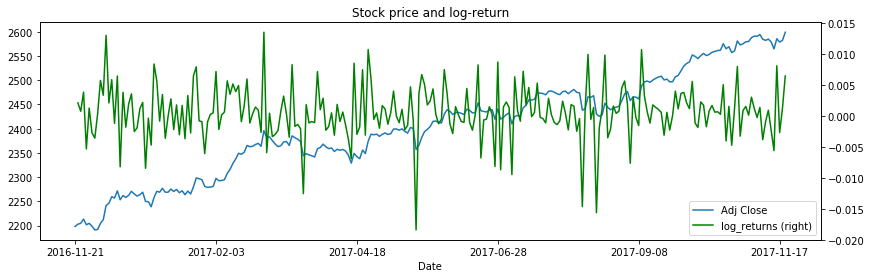

In [141]:
# Import the data
data = pd.read_csv('GSPC.csv')

# Create the log-returns
data = data.assign(log_returns=np.log(data['Adj Close'].values)-np.log(data['Adj Close'].shift(1).values))

# Plot the Adjusted Close prices and log-returns
plt.figure(1)
#handels, labels = ax.get_legend_handles_labels()
ax = data.plot(x='Date', y='Adj Close', figsize=(14,4))
data['log_returns'].plot(secondary_y=True, style='g', legend=True)
ax.get_legend().set_bbox_to_anchor((1,0.2))
plt.title('Stock price and log-return')

Everything seems to be in order. The current price of the stock is 

In [142]:
data.tail(1)

,Date,Open,High,Low,Close,Adj Close,Volume,log_returns
252,2017-11-21,2589.169922,2601.189941,2589.169922,2599.030029,2599.030029,1920976946,0.00652


and the parameters for the closest in the money Call option are $V=\$37.50$ and $K=\$2595.00$. The standard deviation of the historical log-returns, $s$, serves as an estimator for the standard deviation of the stock price, which according to $(42)$ is of the form $\sigma\sqrt{t}$. The term $\sigma$ can be estimated with $s/\sqrt{t}$, and since the historical volatility is calculated from daily log-returns while the quantity of interest is annual volatility, $t$ is one over the number of trading days in a year, taken here to be $252$. The standard error of this estimate is $\sigma_h/\sqrt{2(n-1)}$. With these, and $r=5.215\%$, the historical and implied volatilities can be determined:

In [143]:
# sigma_h is historical volatility
# r is the risk free rate
# sigma_i is the volatility of the stock
# T is the time to maturity in years
# S_0 is the current price of the stock
# K is the stricke price of the option
# V is the observed option price

r = 0.05215
T = 43/252   # 43 days to contract maturity
S_0 = 2599.03
K = 2595.00
V = 37.50

# Calculating the historical volatility from the last 52 days
sigma_h = np.std(np.array(data['log_returns'][200:]))*np.sqrt(252)

# And calculating the implied volatility

sigma_i = e_sigmaImplied(r, sigma_h, T, S_0, K, V)

print(" Historical volatility is", sigma_h, "with standard error", sigma_h/np.sqrt(2*250), "| Implied volatility is:", sigma_i)

 Historical volatility is 0.0504487001559 with standard error 0.0022561344585 | Implied volatility is: 0.0500439569418


Next the option price will be calculated both by Monte Carlo simulation as well as with the closed form solution with historical and implied volatilities. The Monte Carlo simulations will be done with multiple different simulation step numbers in order to investigate the effect it has on the accuracy.

In [144]:
# MC_price_h is the option price calculated with MC and historical volatility
# MC_price_i is the option price calculated with MC and implied volatility
# n is the number of simulation steps in the MC simulation
# BS_price_h is the option price calculated with BS and historical volatility
# BS_price_i is the option price calculated with BS and implied volatility

# Calculate first the option price with Black-Scholes solution
BS_price_h = B_S(sigma_h, r, T, S_0, K)
BS_price_i = B_S(sigma_i, r, T, S_0, K) # For showing that implied volatility was calculated correctly

print("Black-Scholes solution with historical volatility:", BS_price_h)
print("And Black-Scholes solution with sigma_i is of course:", BS_price_i)

Black-Scholes solution with historical volatility: 37.6519127852
And Black-Scholes solution with sigma_i is of course: 37.5000003829


Since the historical volatility calculated is slightly higher, the calculated price is higher as well.

In [61]:
# prices_h is a list of prices calculated with historical volatility with different simulation steps
# prices_i is a list of prices calculated wth implied volatlility with different simulation steps
# computation_time is list of the computation times of the MC routine with different simulation steps, calculated once 

prices_h = []   
prices_i = []
computation_time = []

# Simulations 

for i in range(0,1000000,5000):
    
    if i>0: 
        
        # With historical volatility
        start = time() # Starting the timer
        option1 = europeanOption(i, r, sigma_h, T, S_0, K)
        option1.mcSimulation()
        #V_h, P, S = eMC_optionsBasic(i, r, sigma_h, T, S_0, K)  # Calculate price with MC
        prices_h.append(option1.optionPrice())                                    # Save price
        computation_time.append(time()-start)                   # Save Calculation time
        
        # With implied volatility
        #V_i, P, S = eMC_optionsBasic(i, r, sigma_i, T, S_0, K)
        option2 = europeanOption(i, r, sigma_i, T, S_0, K)
        option2.mcSimulation()
        prices_i.append(option2.optionPrice())     

Next lets plot the simulation results and compare them to the calculated results and also plot how the simulated price converges to the calculated price:

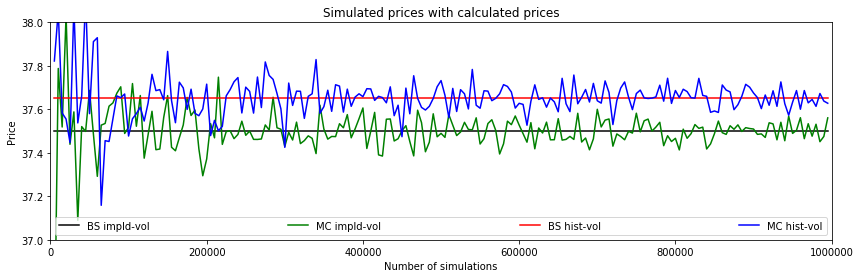

In [62]:
# Valirables to be used in plotting the comparison of simulated prices and calculated prices
x = [i for i in range(5000, 1000000, 5000)]
bsh = [BS_price_h for i in range(199)]
bsi = [BS_price_i for i in range(199)]

# The plot
plt.figure(2)
plt.figure(figsize=(14,4))
plt.xlabel('Number of simulations')
plt.ylabel('Price')
plt.axis([0,1000000,37.0,38.0])
plt.plot(x,bsi,'k',label='BS impld-vol')
plt.plot(x,prices_i,'g', label='MC impld-vol')
plt.plot(x,bsh,'r', label='BS hist-vol')
plt.plot(x,prices_h,'b',label='MC hist-vol')
plt.title('Simulated prices with calculated prices')
plt.legend(loc='lower center', mode='expand', ncol=4)

Text(0.5,1,'Convergence of the simulated price to the calculated price')

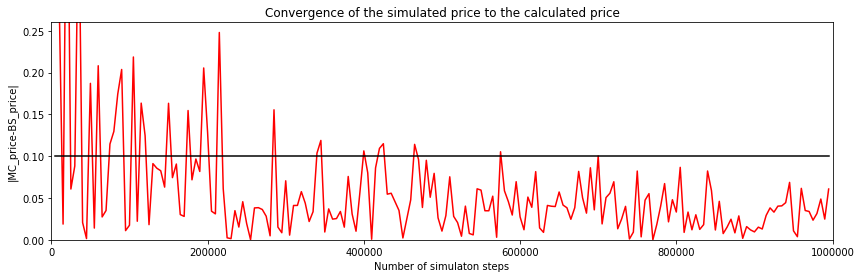

In [63]:
# Absolute value of the difference between calculated price and simulated prices
diff = np.absolute(np.array(prices_i)-bsi)

# Plot of the convergence of simulated price to calculated price
plt.figure(3)
plt.figure(figsize=(14,4))
plt.xlabel('Number of simulaton steps')
plt.ylabel('|MC_price-BS_price|')
plt.axis([0,1000000,0,0.26])
plt.plot(x,diff,'r', x, [0.10 for i in range(199)], 'k')
plt.title('Convergence of the simulated price to the calculated price')

Simulation time is also of great interest, so it will be also plotted against the number of simulation steps:

Text(0.5,1,'Simulation time with different number of steps')

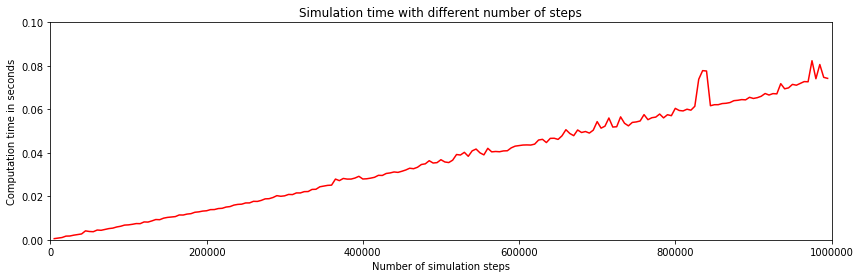

In [69]:
# Plotting the simulation time vs simulation steps
plt.figure(4)
plt.figure(figsize=(14,4))
plt.xlabel('Number of simulation steps')
plt.ylabel('Computation time in seconds')
plt.axis([0,1000000,0,0.10])
plt.plot(x, computation_time, 'r')
plt.title('Simulation time with different number of steps')

Depending on which volatility is used, the simulated prices converge to the corresponding Black-Scholes solution. After around $600000$ simulation steps the estimated price stays pretty well within ten cents from the realized price. The computation time seems to grow pretty much linearly with the simulation steps, being about one tenth of a second at most.

The wastefulness of crude Monte Carlo simulation in this case can be seen from the large standard deviation leading to a large standard error of the estimator and the amount of zeros in simulated option prices:

In [70]:
option = europeanOption(600000, r, sigma_i, T, S_0, K)
option.mcSimulation()
print('Standard error of the simulated prices:', option.error())
print('Number of zero prices simulated in 600000 steps:',option.zeros(), 'or', '%.2f' % ((option.zeros()/600000)*100), 'precent.')

Standard error of the simulated prices: 0.0520196535277
Number of zero prices simulated in 600000 steps: 186848 or 31.14 precent.


In order to try and reduce the error, the method of control variates are explored, and with importance sampling the amount of 'misses' is hopefully lowered.

### Control variates 

In using control variates, not only is the process $Y$, the process under study, simulated but also another process $X$ for which $\mathbb{E}[X]$ is known. Each simulation step $Y_i$ in this scheme becomes

\begin{alignat}{1}
Y_i \Longrightarrow Y_i(c) = Y_i-c\left(X_i-\mathbb{E}[X]\right),
\end{alignat}

where $c$ is a fixed parameter to be optimized. Note that the sample mean still produces and unbiased estimate for $\mathbb{E}[Y]$:

\begin{alignat}{1}
\mathbb{E}[\bar{Y}(c)] = \mathbb{E}\left[\dfrac{1}{n}\sum_{i=1}^n\left(Y_i-c\left(X_i-\mathbb{E}[X]\right)\right)\right] = \mathbb{E}[\bar{Y}-c\left(\bar{X}-\mathbb{E}[X]\right) = \mathbb{E}[Y].
\end{alignat}

The new $Y_i(c)$ have variance

\begin{alignat}{1}
\text{Var}[Y_i(c)] = \text{Var}[Y_i-c(X_i-\mathbb{E}[X])] = \text{Var}[Y_i]-2c\text{Cov}[Y_i,X_i]+c^2\text{Var}[X_i] \equiv \sigma^2(c).
\end{alignat}

While the original estimator had standard error $\sigma/\sqrt{n}$, where $\sigma=\sqrt{\text{Var}[Y]}$ was the standard deviation of $Y_i$'s, the new estimator has standard error $\sigma(c)/\sqrt{n}$ which is a function of $c$. The minimum of $\sigma^2(c)$ is at

\begin{alignat}{2}
&\dfrac{\partial \sigma^2(c)}{\partial c} &&= -2\text{Cov}[Y,X]+2c\text{Var}[X] = 0 \Leftrightarrow c = \dfrac{\text{Cov}[Y,X]}{\text{Var}[X]}.
\end{alignat}

Looking at the ratio of $\sigma^2$ and $\sigma^2(c)$, a condition for reduction in variance can be derived

\begin{alignat}{1}
\dfrac{\sigma^2(c)}{\sigma^2} = \dfrac{\text{Var}[Y]-2\frac{\text{Cov}[Y,X]}{\text{Var}[X]}+\left(\frac{\text{Cov}[Y,X]}{\text{Var}[X]}\right)^2\text{Var}[X]}{\text{Var}[Y]} = 1-\left(\dfrac{\text{Cov}[Y,X]}{\text{Var}[Y]\text{Var}[X]}\right)^2 = 1-\rho_{YX}^2,
\end{alignat}

where $\rho_{YX}$ is the correlation between $Y$ and $X$. A few important things can be deduced immediately. The larger the correlation between $Y$ and $X$ the smaller the standard error of the control variate estimator. Assuming the calculations for a single simulation step are constant, the same standard error achieved for the control variate in $n$ steps takes $1/(1-\rho_{YX}^2)$ steps with the original estimator. Usually Var$[Y]$ and the correlation between $Y$ and $X$ are not known, so an estimate $\hat{c}$ has to be used:

\begin{alignat}{1}
\hat{c} = \dfrac{\sum_{i=1}^n(Y_i-\bar{Y})(X_i-\bar{X})}{\sum_{i=1}^n(X_i-\bar{X})^2}.
\end{alignat}

Equation $(57)$ is immediately recognized as the slope of a regression line through points $(X_i, Y_i)$. A second observation is also to be made: replacing $c$ with $\hat{c}$, the control variate estimator is no longer unbiased: the bias $\mathbb{B} = \mathbb{E}[Y]-\mathbb{E}[\bar{Y}(\hat{c})] = \mathbb{E}[\hat{c}(\bar{X}-\mathbb{E}[X])$ is only zero if the $\hat{c}$ used is independent of $\bar{X}$. This can be achieved by estimating $\hat{c}$ from a different sample than $\bar{X}$ and would thus require additional computational resources. For large sample sizes this is not necessary as the bias is of $\mathcal{O}(1/n)$. In addition to this, since least squares estimates are unbiased, if the regression of $Y_i$'s on $X_i$'s is linear, the control variate estimator is unbiased.

The choice of a good control variate depends on the system at hand. For European options maybe the most obvious control variate is the underlying asset. This would work since in absence of arbitrage appropriately discounted asset prices are martingales; for a current asset price $S(t=0)$, exp$(-rT)S(t)$ is a martingale and $\mathbb{E}[\text{exp}(-rT)S(T)]=S(0)$. Next the above ideas are implemented using the underlying asset as a control variate variable for the option price.

Now the estimator for $V(S(0),0)$ becomes 

\begin{alignat}{1}
\bar{V}(\hat{c})=\dfrac{1}{n}\sum_{i=1}^n\left((e^{-rT}\text{max}(S_i(T)-K,0)-\hat{c}(S_i(T)-e^{-eT}S(0))\right).
\end{alignat}

In order to estimate $\hat{c}$, first vectors $Y_i=e^{-rT}\text{max}(S_i(T)-K,0)$ and $X_i=S_i(T)$ are generated and then $\hat{c}$ will be determined from $(57)$. After this the price and its standard error are calculated.

In [145]:
class controlvariateEuropean:
    
    def __init__(self,n,r,sigma,T,S_0,K):
        self.n, self.r, self.sigma, self.T, self.S0, self.K = n, r, sigma, T, S_0, K
        
    def cv_mcSimulation(self):
        # Method for calculating the option prices now with control variate
        
        # Run the normal MC 
        crudeMC = europeanOption(self.n, self.r, self.sigma, self.T, self.S0, self.K)
        crudeMC.mcSimulation()
        
        # The required quantities from the crude MC
        self.s = crudeMC.stockPrices()
        self.cp = crudeMC.simulatedPrices() 
        
        # Calculate c-hat
        self.c_hat = (np.dot(self.cp-np.mean(self.cp), self.s-np.mean(self.s)))/(np.dot(self.s-np.mean(self.s),
                                                                                      self.s-np.mean(self.s)))
        
        # Simulate the prices using control variate
        self.P = self.cp-self.c_hat*(self.s-np.exp(self.r*self.T)*self.S0)
        
    def simulatedPrices(self):
        # Return simulated prices
        return self.P
    
    def error(self):
        # Return standard error
        self.COV = np.cov(self.cp, self.s, ddof=1) # Covariance matrix
        return np.sqrt((self.COV[0][0]-2*self.c_hat*self.COV[0][1]+np.power(self.c_hat,2)*self.COV[1][1])/(self.n))
                                    
    def optionPrice(self):
        # Return estimated price for the option
        return np.mean(self.P)
    
    def crudeCalculations(self):
        # Return price estimated with crude MC and the standard error
        return np.mean(self.cp), np.std(self.cp,ddof=1)/np.sqrt(self.n) 

Doing the same price convergence plot as above and looking at how the standard error behaves as a function of simulation steps, the following plots are obtained:

In [146]:
prices_V = []   
prices_V_cv = []
standard_error_V = []    # Standard error of the crude MC
standard_error_V_cv = [] # Standard error of control variate MC

# Simulations 

for i in range(0,1000000,5000):
    
    if i>0: 
         
        # Doing the simulation
        option = controlvariateEuropean(i,r,sigma_i,T,S_0,K)
        option.cv_mcSimulation()
        crude_price, crude_error = option.crudeCalculations()
        prices_V.append(crude_price)
        prices_V_cv.append(option.optionPrice())
        standard_error_V.append(crude_error)
        standard_error_V_cv.append(option.error())

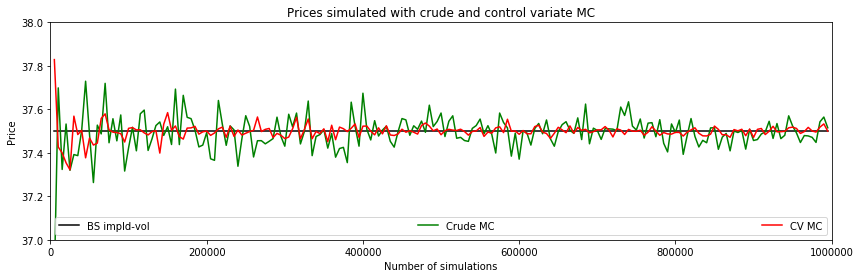

In [147]:
# Plots

# Valirables to be used in plotting the comparison of simulated prices and calculated prices
x = [i for i in range(5000, 1000000, 5000)]
bsi = [BS_price_i for i in range(199)]

# The plot
plt.figure(6)
plt.figure(figsize=(14,4))
plt.xlabel('Number of simulations')
plt.ylabel('Price')
plt.axis([0,1000000,37.0,38.0])
plt.plot(x,bsi,'k',label='BS impld-vol')
plt.plot(x,prices_V,'g', label='Crude MC')
plt.plot(x,prices_V_cv,'r',label='CV MC')
plt.title('Prices simulated with crude and control variate MC')
plt.legend(loc='lower center', mode='expand', ncol=3)
        

Text(0.5,1,'Convergence of the simulated prices to the calculated price')

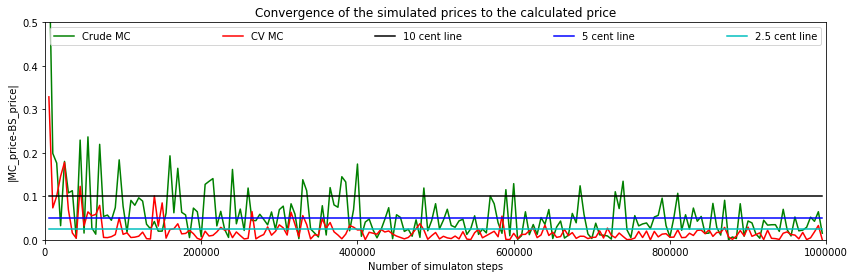

In [148]:
# Absolute value of the difference between calculated price and simulated prices
diff = np.absolute(np.array(prices_V)-bsi)
diff_cv = np.absolute(np.array(prices_V_cv)-bsi)

# Plot of the convergence of simulated price to calculated price
plt.figure(7)
plt.figure(figsize=(14,4))
plt.xlabel('Number of simulaton steps')
plt.ylabel('|MC_price-BS_price|')
plt.axis([0,1000000,0,0.5])
plt.plot(x,diff,'g', label='Crude MC')
plt.plot(x, diff_cv, 'r', label='CV MC')
plt.plot(x, [0.10 for i in range(199)], 'k', label='10 cent line')
plt.plot(x, [0.05 for i in range(199)], 'b', label='5 cent line')
plt.plot(x, [0.025 for i in range(199)], 'c', label='2.5 cent line')
plt.legend(loc='upper center', mode='expand', ncol=5)
plt.title('Convergence of the simulated prices to the calculated price')

and the standard error of these two estimators can be compared by plotting them against the simulation steps:

Text(0.5,1,'Comparison of standard errors as a function of simulation steps')

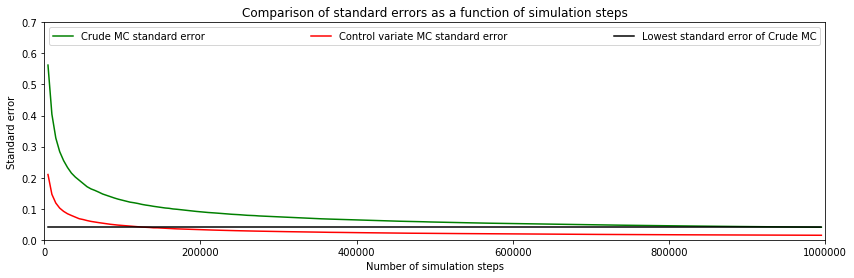

In [149]:
plt.figure(8)
plt.figure(figsize=(14,4))
plt.xlabel('Number of simulation steps')
plt.ylabel('Standard error')
plt.axis([0,1000000,0,0.7])
plt.plot(x,standard_error_V, 'g', label='Crude MC standard error')
plt.plot(x,standard_error_V_cv, 'r', label='Control variate MC standard error')
plt.plot(x, [standard_error_V[-1] for i in range(199)], 'k', label='Lowest standard error of Crude MC')
plt.legend(loc='upper center', mode='expand', ncol=3)
plt.title('Comparison of standard errors as a function of simulation steps')

One thing becomes very clear, using the underlying asset as a control variate reduces the standard error substantially faster. The new price converges to about $0.07\%$ of the correct price in the amount of steps the original estimator converged to about $0.27\%$ and the standard error that the original estimator reached in $1000000$ steps is reached in less than $200000$ steps by the new estimator. 


More analysis coming up....

### Importance sampling

Here comes the basic idea of importance sampling and the change in measure. 

In [205]:
class importanceEuropean:
    
    def __init__(self,n,r,sigma,T,S_0,K):
        self.n, self.r, self.sigma, self.T, self.S0, self.K = n, r, sigma, T, S_0, K
        
    def is_mcSimulation(self):
        
        # Calculate some values in advance for speed
        x_1 = (np.log(self.K/self.S0)-0.5*(self.sigma**2))*self.T
        x_2, x_3 = self.sigma*np.sqrt(self.T), np.exp(-self.r*self.T)
        x_4 = (self.r-0.5*(self.sigma**2))*self.T
        
        # Vector of random variables
        Z = x_1+x_2*np.random.randn(self.n)
        
        # Simulate the stock prices
        self.S = self.S0*np.exp(Z)
        
        # Simulate the option prices
        pdf_1 = stats.norm.pdf(Z, loc=x_4, scale=x_2)
        pdf_2 = stats.norm.pdf(Z, loc=x_1, scale=x_2)
        self.pp = pdf_1/pdf_2
        #self.pp = np.exp((-((Z-x_4)**2)+((Z-x_1)**2))/2*(x_2**2))
        self.P = x_3*np.maximum(self.S-self.K,0)*self.pp
        
    def stockPrices(self):
        # Return the simulated stock prices
        return self.S
    
    def simulatedPrices(self):
        # Return the simulated option prices
        return self.P
    
    def optionPrice(self):
        # Return the price of the option
        return np.mean(self.P)
    
    def error(self):
        # Return the standard error of the estimate
        return np.std(self.P, ddof=1)/np.sqrt(self.n)
    
    def zeros(self):
        # Return the number of zeros in simulation
        return sum([1 if i==0 else 0 for i in self.P])
        
        

# Fortran code

In [ ]:
%load_ext fortranmagic

In [ ]:
%%fortran -vvv --f90flags="-fopenmp" --extra="-lgomp" --opt='-O3'
module derivatives
    implicit none
    
    integer, parameter :: rk=selected_real_kind(10,40)
    integer, parameter :: ik=selected_int_kind(10)
    
    !-------------------------------------------------------------------------
    integer,parameter,private :: defaultsd = 4357    ! Default seed       
    integer,parameter,private :: N = 624, N1 = N + 1 ! Period parameters
    integer,dimension(0:N-1),private :: mt      ! Array for the state vector
    integer,private :: mti = N1
    !-------------------------------------------------------------------------
            
contains
    ! Subroutine for calculating prices for European and Asian call options
    subroutine eurasian(n, j, d_t, S_0, mu, sigma, T, K, P_T)
        use omp_lib
        implicit none
                
        integer, parameter :: rk=selected_real_kind(10,40)
        real(kind=rk), intent(in) :: S_0, mu, sigma, T, K
        integer, intent(in) :: n, j, d_t
        real(kind=rk), intent(out) :: P_T(j)        
        
        
        real(kind=rk), allocatable :: P_i(:,:), P(:)
        
        integer :: thread_n, l, i
        
        l = n/4
            
        call omp_set_num_threads(4)
        allocate(P_i(l,4), P(n))
        
        do i=1,j
            ! Go parallel
        
            !$omp parallel private(thread_n) 
    
            thread_n = omp_get_thread_num()
    
            if (thread_n==0) then
                if (d_t==0) then
                    call e_mc(l, S_0, mu, sigma, T, K, P_i(:,1), thread_n)
                else
                    call a_mc(d_t, l, S_0, mu, sigma, T, K, P, thread_n)
                end if
            end if
    
            if (thread_n==1) then
                if (d_t==0) then
                    call e_mc(l, S_0, mu, sigma, T, K, P_i(:,2), thread_n)
                else
                    call a_mc(d_t, l, S_0, mu, sigma, T, K, P, thread_n)
                end if
            end if
    
            if (thread_n==2) then
                if (d_t==0) then
                    call e_mc(l, S_0, mu, sigma, T, K, P_i(:,3), thread_n)
                else
                    call a_mc(d_t, l, S_0, mu, sigma, T, K, P, thread_n)
                end if
            end if
    
            if (thread_n==3) then
                if (d_t==0) then
                    call e_mc(l, S_0, mu, sigma, T, K, P_i(:,4), thread_n)
                else
                    call a_mc(d_t, l, S_0, mu, sigma, T, K, P, thread_n)
                end if
            end if   
    
            !$omp end parallel
        
            P(1:l) = P_i(:,1)
            P(l+1:2*l) = P_i(:,2)
            P(2*l+1:3*l) = P_i(:,3)
            P(3*l+1:4*l) = P_i(:,4)
        
            P_T(i) = sum(P)/n
        end do
        
    end subroutine eurasian
    
    ! Monte Carlo subroutine for European Call option
    subroutine e_mc(l, S_0, mu, sigma, T, K, P, thread_n)
        implicit none
        
        integer, parameter :: rk=selected_real_kind(10,40)
        
        real(kind=rk), intent(in) :: S_0, mu, sigma, T, K
        integer, intent(in) :: l        
        real(kind=rk), intent(inout) :: P(l)
        integer, intent(in) :: thread_n
            
        real(kind=rk) :: Z, S, x_1, x_2, x_3
        integer :: i
    
        x_1 = (mu-(0.5d0)*(sigma**2))*T
        x_2 = sigma*sqrt(T)
        x_3 = exp(-mu*T)
    
        call sgrnd(getseed(info=thread_n+1))
    
        do i=1,l
            Z = gaussrnd()
            S = S_0*exp(x_1+x_2*Z)
            P(i) = x_3*max(S-K, 0.0d0)
        end do
        
    end subroutine e_mc
    
    ! Monte Carlo subroutine for Asian Call option
    subroutine a_mc(d_t, l, S_0, mu, sigma, T, K, P, thread_n)
        implicit none
        
        integer, parameter :: rk=selected_real_kind(10,40)
        
        real(kind=rk), intent(in) :: S_0, mu, sigma, T, K
        integer, intent(in) :: l        
        real(kind=rk), intent(inout) :: P(l)
        integer, intent(in) :: d_t, thread_n
                
        real(kind=rk) :: Z, S, S_i, S_bar, x_1, x_2, x_3
        integer :: i, j
        
        x_1 = (mu-(0.5d0)*(sigma**2))*(T/d_t)
        x_2 = sigma*sqrt(T/d_t)
        x_3 = exp(-mu*T)
        
        call sgrnd(getseed(info=thread_n+1))
        
        do i=1,l
            S = S_0
            do j=1,d_t
                Z = gaussrnd()
                S_i = S*exp(x_1+x_2*Z)
                S = S_i
            end do
            S_bar = S/d_t
            P(i) = x_3*max(S_bar-K, 0.0d0)
        end do
    
    end subroutine a_mc
    
!-----------------------------------------------------------------------------------------------------------------------!  
!-----------------------------------------------------------------------------------------------------------------------!    
    !-----------------------------------------!
    ! Mersenne Twister random number generator!
    !-----------------------------------------!
    !---------------------------------------------------------------!
    ! Initialization subroutine                                     !
    !---------------------------------------------------------------!

    subroutine sgrnd(seed)
        implicit none
        ! Setting initial seeds to mt[N] using the generator Line 25 of Table 1 in
        ! [KNUTH 1981, The Art of Computer Programming Vol. 2 (2nd Ed.), pp102]
        integer, intent(in) :: seed    
        mt(0) = iand(seed,-1)
        do mti=1,N-1
           mt(mti) = iand(69069 * mt(mti-1),-1)
        enddo
        return
    end subroutine sgrnd
    
    !---------------------------------------------------------------!
    ! Random number generator: [0,1[                                !                                                              !
    !---------------------------------------------------------------!

    function grnd()
        implicit none
        
        integer, parameter :: rk=selected_real_kind(10,40)
        integer, parameter :: ik=selected_int_kind(10)
                                    
                                    
        real(kind=rk) :: grnd    
        ! Period parameters
        integer, parameter :: M = 397, MATA  = -1727483681 ! constant vector a
        integer, parameter :: LMASK =  2147483647          ! least significant r bits
        integer, parameter :: UMASK = -LMASK - 1           ! most significant w-r bits
        ! Tempering parameters
        integer, parameter :: TMASKB= -1658038656, TMASKC= -272236544    
        integer,save :: mag01(0:1)=[0,MATA] ! mag01(x) = x * MATA for x=0,1
    
        integer :: kk,y

        if (mti>=N) then               ! generate N words at one time
            if (mti==N+1) then          ! if sgrnd() has not been called,
                call sgrnd( defaultsd ) ! a default initial seed is used
            endif
            do kk=0,N-M-1
                y=ior(iand(mt(kk),UMASK),iand(mt(kk+1),LMASK))
                mt(kk)=ieor(ieor(mt(kk+M),ishft(y,-1)),mag01(iand(y,1)))
            enddo
            do kk=N-M,N-2
                y=ior(iand(mt(kk),UMASK),iand(mt(kk+1),LMASK))
                mt(kk)=ieor(ieor(mt(kk+(M-N)),ishft(y,-1)),mag01(iand(y,1)))
            enddo
            y=ior(iand(mt(N-1),UMASK),iand(mt(0),LMASK))
            mt(N-1)=ieor(ieor(mt(M-1),ishft(y,-1)),mag01(iand(y,1)))
            mti = 0
        endif
    
        y=mt(mti)
        mti = mti + 1 
        y=ieor(y,TSHFTU(y))
        y=ieor(y,iand(TSHFTS(y),TMASKB))
        y=ieor(y,iand(TSHFTT(y),TMASKC))
        y=ieor(y,TSHFTL(y))
    
        if (y<0) then
            grnd=(dble(y)+2.0d0**32)/(2.0d0**32-1.0d0)
        else
            grnd=dble(y)/(2.0d0**32-1.0d0)
        endif
    
        return

    contains

        integer function TSHFTU(y)
        integer,intent(in) :: y
        TSHFTU=ishft(y,-11)
        return
        end function TSHFTU
        integer function TSHFTS(y)
        integer,intent(in) :: y
        TSHFTS=ishft(y,7)
        return
        end function TSHFTS
        integer function TSHFTT(y)
        integer,intent(in) :: y
        TSHFTT=ishft(y,15)
        return
        end function TSHFTT
        integer function TSHFTL(y)
        integer,intent(in) :: y
        TSHFTL=ishft(y,-18)
        return
        end function TSHFTL

    end function grnd
                                    
    !---------------------------------------------------------------!
    ! Integer random number generator [l,j]:                        !
    !---------------------------------------------------------------!

    integer function igrnd(l,h)
        implicit none
        integer,intent(in) :: l,h
        real(kind=rk) :: u,r
        u=grnd()
        r=(h-l+1)*u+l
        igrnd=int(r)
        return
    end function igrnd

    !---------------------------------------------------------------!
    ! Random numbers with normal (0,1 Gaussian) distribution.       !
    !---------------------------------------------------------------!  
  
    function gaussrnd()
        implicit none
        
        integer, parameter :: rk=selected_real_kind(10,40)
        integer, parameter :: ik=selected_int_kind(10)                       
                                    
        real(kind=rk) :: gaussrnd
        real(kind=rk) :: fac,v1,v2,r
        real(kind=rk), save :: gset
        integer, save :: iset=0

        if (iset==0) then ! Create a new RN
            r=100.0
            do while (r>1.0)
                v1 = 2.0*grnd()-1.0
                v2 = 2.0*grnd()-1.0
                r = v1*v1+v2*v2
            end do
            fac = sqrt(-2.0*log(r)/r)
            gset = v1*fac
            gaussrnd = v2*fac
            iset = 1
        else ! Use the 2nd NR from the previous call
            gaussrnd = gset
            iset = 0
        endif
        return
    end function gaussrnd
                                    
    !------------------------------------------------------!
    !  Get the RNG seed from /dev/urandom device.          !
    !------------------------------------------------------!
    
    integer function getseed(info,file)
  
        implicit none
        integer,optional,intent(in) :: info,file
        integer :: t(8),rn,is
        integer,parameter :: LMASK=huge(rn) ! = 0111...111
        integer,parameter :: LUN=676769
        character (len=80) :: rdev0='/dev/urandom',rdev1='/dev/random',rdev
        logical :: openok,readok,printinfo

        openok=.true.
        readok=.true.

        if (present(file)) then
            if (file==0) then
                rdev=rdev0
            else
                rdev=rdev1
            end if
        else
            rdev=rdev0
        end if
        if (present(info)) then
            printinfo=(info/=0)
        else
            printinfo=.false.
        end if

        open(LUN,file=rdev,form='unformatted',access='stream',action='read',iostat=is)
        if (is/=0) then
            openok=.false.
            print *,'open',is
        else
            read(LUN,iostat=is) rn
            if (is/=0) then
                readok=.false.
            end if
        end if
        if (openok) close(LUN)

        if (openok.and.readok) then
            rn=iand(rn,LMASK) ! Make it positive, i.e. zero the leftmost bit
            if (printinfo) write(6,'(a,a,a,i0)') 'Seed from ',trim(rdev),': ',rn
        else
            call date_and_time(values=t)
            rn=t(7)+60*(t(6)+60*(t(5)+24*(t(3)-1+31*(t(2)-1+12*t(1)))))+t(8)
            if (printinfo) write(6,'(a,i12)') 'Seed from time:',rn
        end if

    getseed=rn
    return
  end function getseed
!------------------------------------------------------------------------------------------------------------------------!
end module derivatives 
                
        
    
    